In [2]:
%pip install imageio

import json
import matplotlib.pyplot as plt
import numpy as np
import imageio.v2 as imageio
import scipy.signal as signal
import statistics




[notice] A new release of pip is available: 23.3 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
def load_json(group,student):
    with open(f'./data/all_json/{group}_{student}.json') as f:
        return json.load(f)
    
def load_images(group,student):
    images =  imageio.imread(f'{group}-{student}.tif')
    return np.mean(images,axis=3)


def show_image(group,student,frame):
    plt.figure(figsize=(15,10))
    data = load_json(group,student)
    images = load_images(group,student)
    plt.imshow(images[frame-1], cmap='gray')
    plt.title(f'{group}-{student} frame {frame}')
    data = data['{}_{}_frame_{}'.format(group,student,frame)]
    for d in data["boxes"]:
        rect = plt.Rectangle((d[0], d[1]), d[2], d[3], fill=False, color='red')
        plt.gca().add_patch(rect)
    
    for d in data["cells"]:
        plt.plot(d[0], d[1], 'ro', markersize=2) 
    plt.show()

In [4]:
frame_number = 29
threshold = 0.2
group = 9
student = 3

In [5]:
# data = load_json(group,student)
images = load_images(group,student)

/home/codespace/.python/current/lib/python3.10/site-packages/imageio/plugins/_tifffile.py:3346: UserWarning: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
  warnings.warn(str(e))


In [6]:
# show_image(group,student,frame_number)  

## Background definition

In [7]:
def back_mean(images, nb_frames=60):
    background = np.mean(images[:nb_frames],axis=(0))
    return background


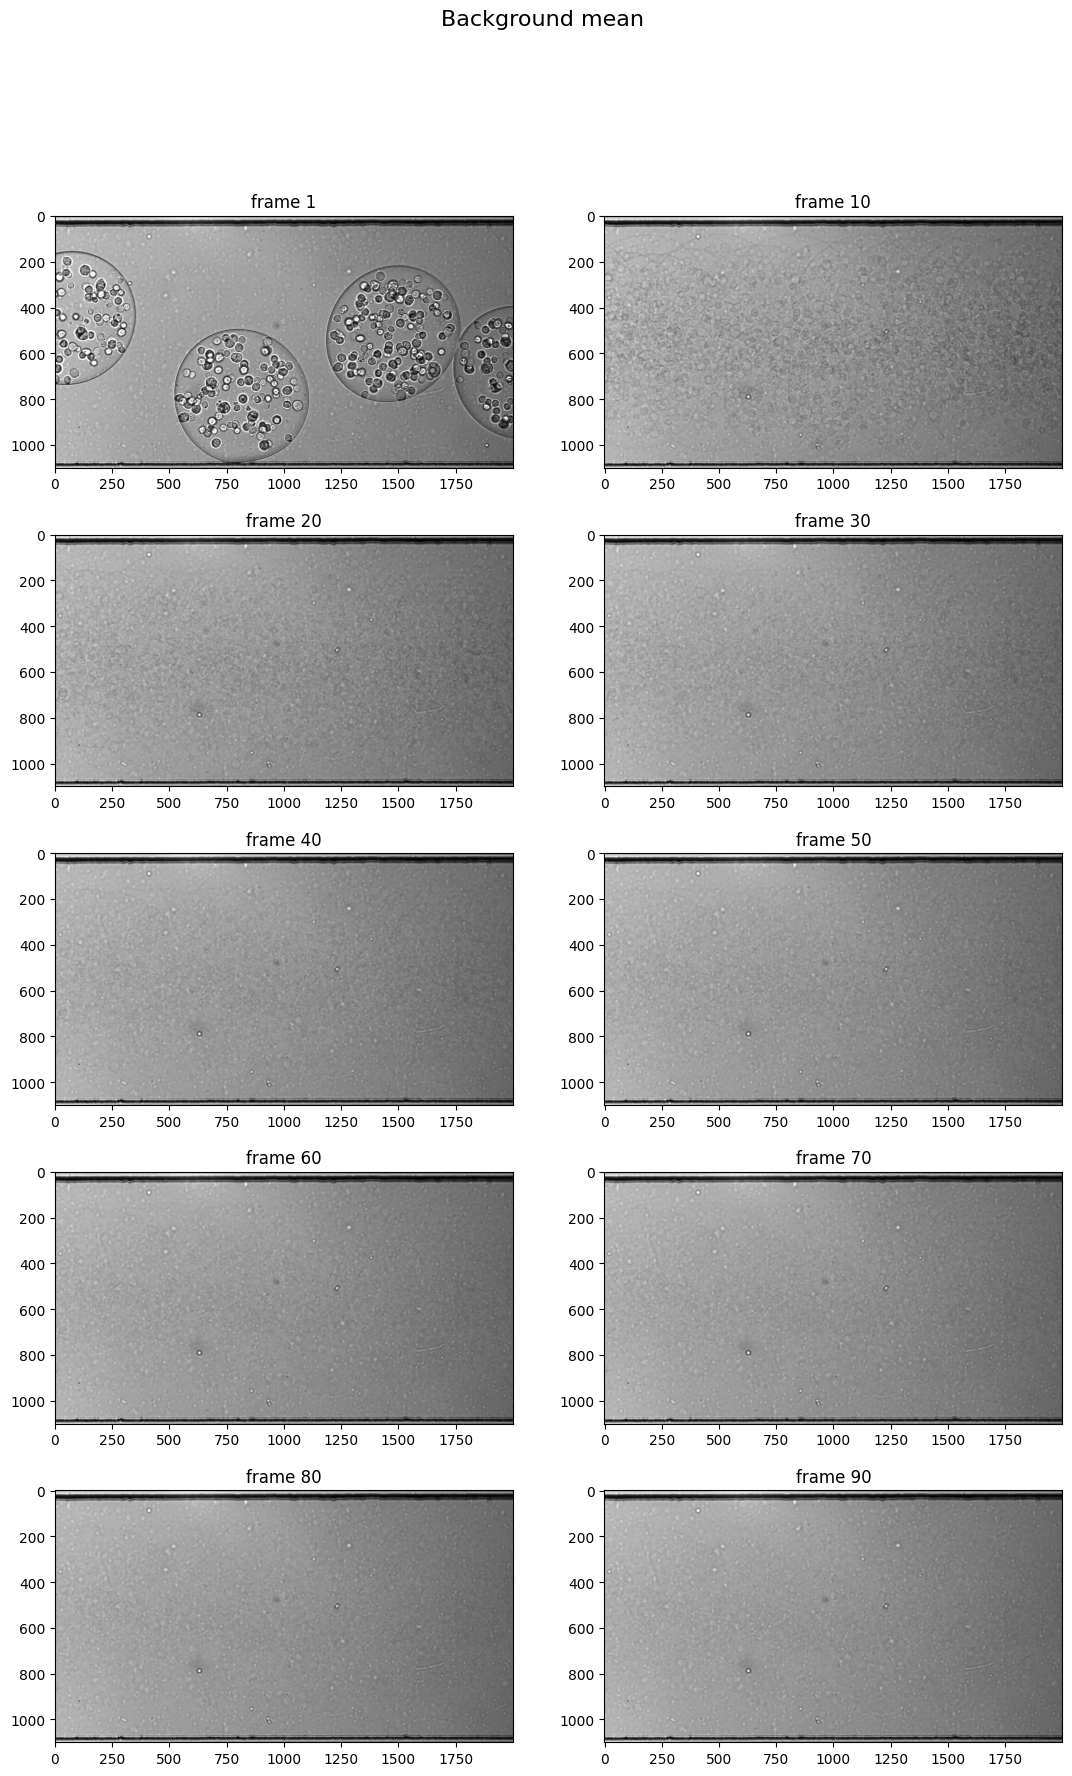

In [8]:
fig, axs = plt.subplots(5,2, figsize=(13,20))
fig.suptitle('Background mean', fontsize=16)
axs[0,0].imshow(back_mean(images,1), cmap='gray')
axs[0,0].set_title(f'frame {1}')
for i in range(1,10):
    axs[i//2,i%2].imshow(back_mean(images, i*10), cmap='gray')
    axs[i//2,i%2].set_title(f'frame {i*10}')
plt.show()

In [9]:
def column_energy_one(column):
    return np.sum(np.diff(column)**2)

def column_energy_integrated(column, previous = 1):
    energy = 0
    for i in range(previous):
        rolling = np.roll(column, 1)
        energy += np.sum(np.subtract(column,rolling)**2)
    return energy

def column_energy_var(column):
    return statistics.variance(column)

In [10]:
fig, axs = plt.subplots(5, 2, figsize=(13, 20))
fig.suptitle('Background variance', fontsize=16)

for k in range(1, 10):
    nb_samples = k*10
    if k == 1:
        nb_samples = 1
    indexes = []
    images_mean = images
    images_nobound = images_mean[:nb_samples, 100:-80, :]

    mean = np.mean(images_nobound)
    images_test = (images_nobound - mean)**4
    column_mean = np.mean(images_test, axis=1)
    indexes = []

    for i in range(column_mean.shape[1]):
        indexes.append(
            list(zip(*np.where(column_mean[:, i] == min(column_mean[:, i])))))

    background_energy = np.zeros(
        (images.shape[1], images.shape[2], 3), dtype=np.uint8)
    for i in range((background_energy.shape)[0]):
        for j in range((background_energy.shape)[1]):
            background_energy[i][j][:] = images_mean[int(
                indexes[j][0][0]), i, j]

    axs[k//2, k % 2].imshow(background_energy, cmap='gray')
    axs[k//2, k % 2].set_title(f'frame {k*10}')
plt.show()

: 

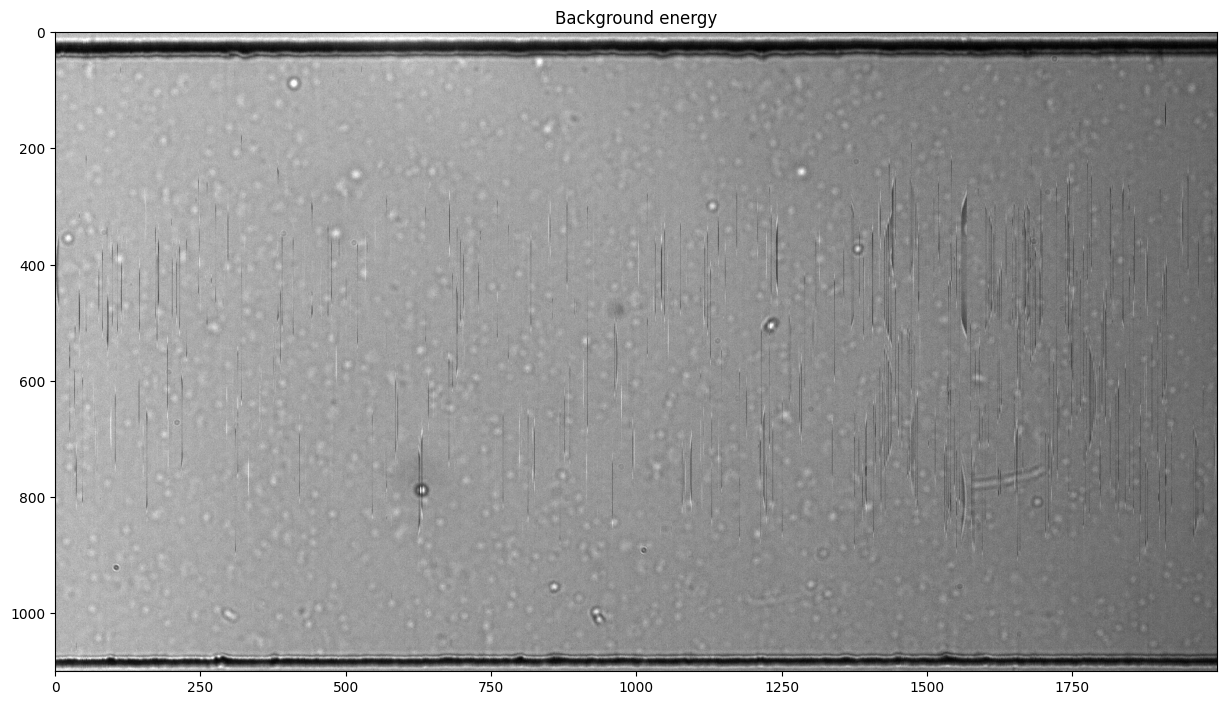

In [ ]:
# Background creation


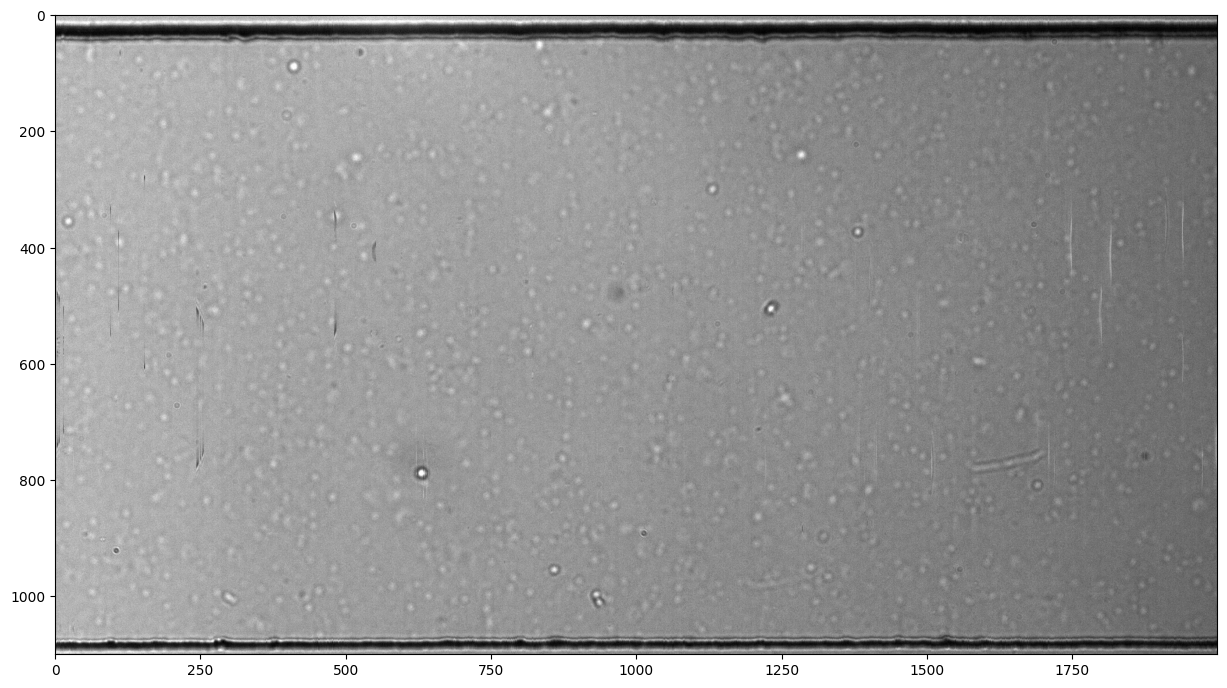

In [ ]:
nb_samples = 20
indexes = []
images_nobound = images[:nb_samples, 100:-80, :]
keep = True
index = 0

mean = np.mean(images_nobound)
images_test = (images_nobound - mean)**4
column_mean = np.mean(images_test, axis=1)
indexes = []

for i in range(column_mean.shape[1]):
    indexes.append(
        list(zip(*np.where(column_mean[:, i] == min(column_mean[:, i])))))

background_energy = np.zeros(
    (images.shape[1], images.shape[2], 3), dtype=np.uint8)
for i in range((background_energy.shape)[0]):
    for j in range((background_energy.shape)[1]):
        background_energy[i][j][:] = images[int(indexes[j][0][0]), i, j]

plt.figure(figsize=(15, 10))
plt.imshow(background_energy, cmap='gray')

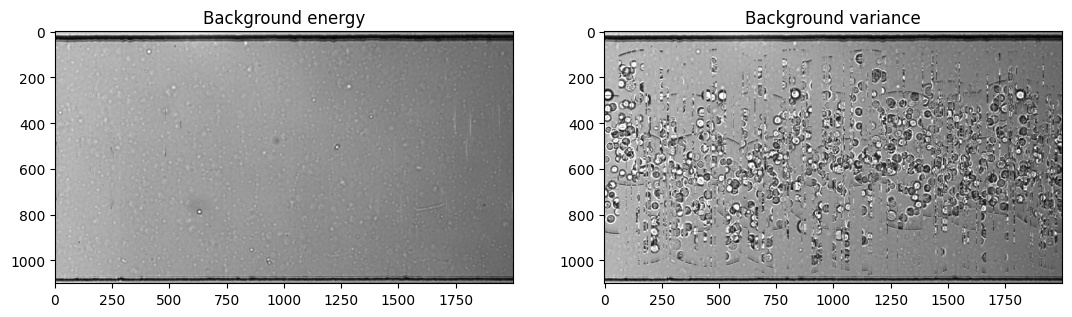

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(13,20))
axs[0].imshow(background_energy, cmap='gray')
axs[0].set_title('Background energy')
axs[1].imshow(background_var, cmap='gray')
axs[1].set_title('Background variance')

plt.show()